<a href="https://colab.research.google.com/github/truemanhama/FUTURE_ML_01/blob/main/SalesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# STEP 1: Install Prophet (only once)
# pip install prophet

from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt


In [29]:
# STEP 2: Load and preprocess the dataset
df = pd.read_csv('/content/mock_kaggle.csv')
df['data'] = pd.to_datetime(df['data'])

# Rename columns for Prophet
df_prophet = df.rename(columns={
    'data': 'ds',
    'venda': 'y',
    'preco': 'preco',
    'estoque': 'estoque'
})

In [30]:
# STEP 3: Split data into training and test sets
# Reserve last 90 days for testing
train_df = df_prophet[:-90].copy()
test_df = df_prophet[-90:].copy()

# STEP 4: Initialize the Prophet model and add regressors
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.add_regressor('preco')
model.add_regressor('estoque')

In [31]:
# STEP 5: Fit the model on the training data
%%time
model.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwh_kf9ap/hea6_xvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwh_kf9ap/p69aitog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4283', 'data', 'file=/tmp/tmpwh_kf9ap/hea6_xvl.json', 'init=/tmp/tmpwh_kf9ap/p69aitog.json', 'output', 'file=/tmp/tmpwh_kf9ap/prophet_modelsm468ktk/prophet_model-20250721200439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:04:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 64.2 ms, sys: 2.77 ms, total: 67 ms
Wall time: 115 ms


In [32]:
# STEP 6: Create future dataframe for prediction (includes both train + test period)
future = model.make_future_dataframe(periods=90)

# Merge with regressor values
future = future.merge(df_prophet[['ds', 'preco', 'estoque']], on='ds', how='left')
future['preco'].fillna(method='ffill', inplace=True)
future['estoque'].fillna(method='ffill', inplace=True)

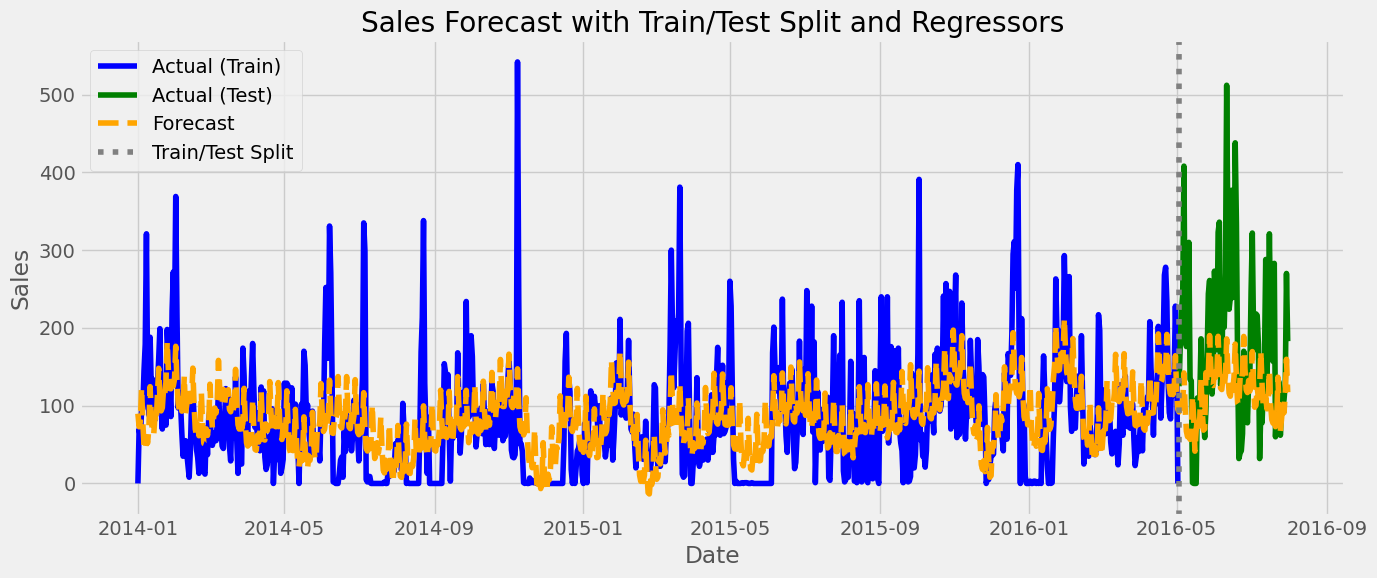

In [37]:
import matplotlib.pyplot as plt

# STEP 8: Custom Plot with Color-Coded Sections

# Merge forecast with actuals
forecast_full = forecast[['ds', 'yhat']].copy()
forecast_full = forecast_full.merge(df_prophet[['ds', 'y']], on='ds', how='left')

# Define train/test periods
train_end_date = train_df['ds'].max()
test_start_date = test_df['ds'].min()

# Create plot
plt.figure(figsize=(14, 6))

# Plot actual training data
plt.plot(train_df['ds'], train_df['y'], label='Actual (Train)', color='blue')

# Plot actual test data
plt.plot(test_df['ds'], test_df['y'], label='Actual (Test)', color='green')

# Plot predictions (entire range)
plt.plot(forecast_full['ds'], forecast_full['yhat'], label='Forecast', color='orange', linestyle='--')

# Mark vertical line to separate train/test
plt.axvline(x=test_start_date, color='gray', linestyle=':', label='Train/Test Split')

# Labels and legend
plt.title("Sales Forecast with Train/Test Split and Regressors")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
# STEP 10: Evaluate performance on test set
# Merge actual test values with forecast
forecast_test = forecast[['ds', 'yhat']].merge(test_df[['ds', 'y']], on='ds', how='inner')

# Calculate MAE or RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(forecast_test['y'], forecast_test['yhat'])
rmse = mean_squared_error(forecast_test['y'], forecast_test['yhat'])
rmse = rmse**0.5 # Calculate RMSE by taking the square root of MSE

print(f"MAE on Test Set: {mae:.2f}")
print(f"RMSE on Test Set: {rmse:.2f}")

MAE on Test Set: 82.49
RMSE on Test Set: 106.47
